In [1]:
# Cell A — install libs and make folders
!pip install -q pandas numpy matplotlib dash plotly pyngrok
import os
os.makedirs('data', exist_ok=True)
os.makedirs('assets', exist_ok=True)
print("Environment ready. Folders created: data/, assets/")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 54.8 MB/s eta 0:00:00
Environment ready. Folders created: data/, assets/


In [2]:
# Cell B — generate synthetic dataset
import pandas as pd, numpy as np
np.random.seed(123)
n = 1200

income = np.random.normal(60000, 25000, n).clip(5000, 300000).round(0)
loan_amount = (income * np.random.uniform(0.08, 0.75, n)).round(0)
term = np.random.choice([12,24,36,48,60], n, p=[0.05,0.15,0.5,0.2,0.1])
interest_rate = np.random.normal(11,2.5,n).clip(6,24).round(2)
credit_score = np.random.normal(680,60,n).clip(300,900).round(0)
utilization = (loan_amount / (income + 1)).round(3)   # avoid div0

default_prob = np.clip(0.12 + (700-credit_score)/220 + (utilization-0.35)*0.6 + (term-36)/200, 0.01, 0.95)
default = np.random.binomial(1, default_prob)

region = np.random.choice(["Mumbai","Pune","Delhi","Bengaluru","Chennai"], n)
branch = np.random.choice(["HDFC-M1","HDFC-M2","HDFC-P1","HDFC-D1","HDFC-B1","HDFC-C1"], n)

df = pd.DataFrame({
    "loan_id": [f"HDFC_L{20000+i}" for i in range(n)],
    "customer_id": [f"HDFC_C{30000+i}" for i in range(n)],
    "income": income.astype(int),
    "loan_amount": loan_amount.astype(int),
    "term_months": term,
    "interest_rate": interest_rate,
    "credit_score": credit_score.astype(int),
    "utilization": utilization,
    "default": default,
    "region": region,
    "branch": branch
})

df.to_csv('data/hdfc_sample_loans.csv', index=False)
print("Saved synthetic dataset: data/hdfc_sample_loans.csv  (rows: {})".format(len(df)))
df.head()


Saved synthetic dataset: data/hdfc_sample_loans.csv  (rows: 1200)


,loan_id,customer_id,income,loan_amount,term_months,interest_rate,credit_score,utilization,default,region,branch
0,HDFC_L20000,HDFC_C30000,32859,14924,36,8.45,818,0.454,0,Delhi,HDFC-C1
1,HDFC_L20001,HDFC_C30001,84934,55698,36,9.47,700,0.656,0,Delhi,HDFC-C1
2,HDFC_L20002,HDFC_C30002,67074,34561,36,9.58,677,0.515,0,Pune,HDFC-B1
3,HDFC_L20003,HDFC_C30003,22343,12292,48,13.88,637,0.550,0,Mumbai,HDFC-B1
4,HDFC_L20004,HDFC_C30004,45535,10244,36,15.24,664,0.225,0,Mumbai,HDFC-P1


In [3]:
# Cell C — preprocess and feature-engineer
import pandas as pd, numpy as np
df = pd.read_csv('data/hdfc_sample_loans.csv')

df['income_to_loan'] = (df['income'] / df['loan_amount'].replace(0, np.nan)).round(3)
df['high_util'] = (df['utilization'] > 0.65).astype(int)
df['low_credit'] = (df['credit_score'] < 620).astype(int)
df['term_long'] = (df['term_months'] >= 48).astype(int)
df['credit_bucket'] = pd.cut(df['credit_score'],
                             bins=[299,579,639,699,749,900],
                             labels=['300-579','580-639','640-699','700-749','750+'])

df.to_csv('data/hdfc_processed_loans.csv', index=False)
print("Saved processed file: data/hdfc_processed_loans.csv")
df[['income','loan_amount','credit_score','utilization','income_to_loan','high_util','credit_bucket']].head()


Saved processed file: data/hdfc_processed_loans.csv


,income,loan_amount,credit_score,utilization,income_to_loan,high_util,credit_bucket
0,32859,14924,818,0.454,2.202,0,750+
1,84934,55698,700,0.656,1.525,1,700-749
2,67074,34561,677,0.515,1.941,0,640-699
3,22343,12292,637,0.550,1.818,0,580-639
4,45535,10244,664,0.225,4.445,0,640-699


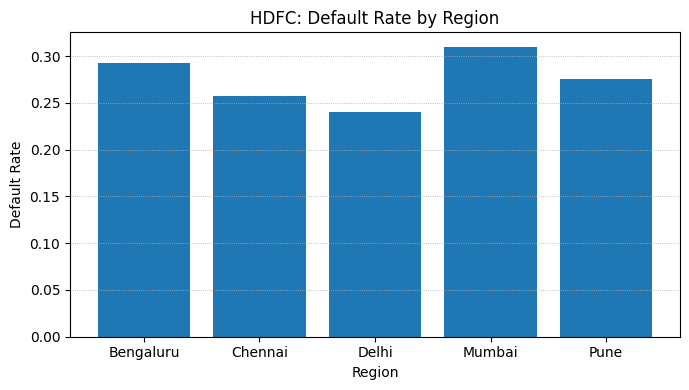

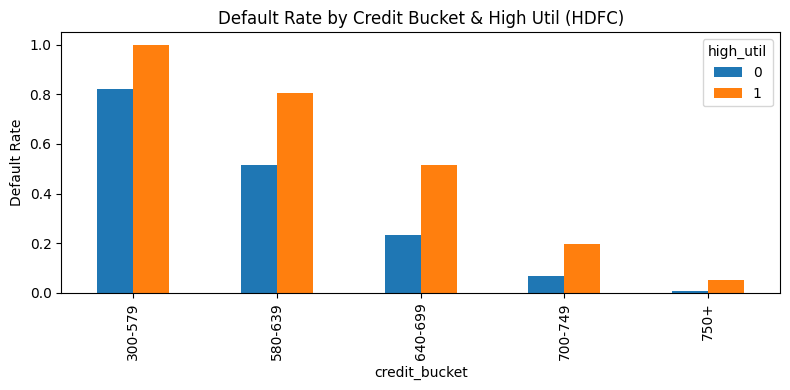

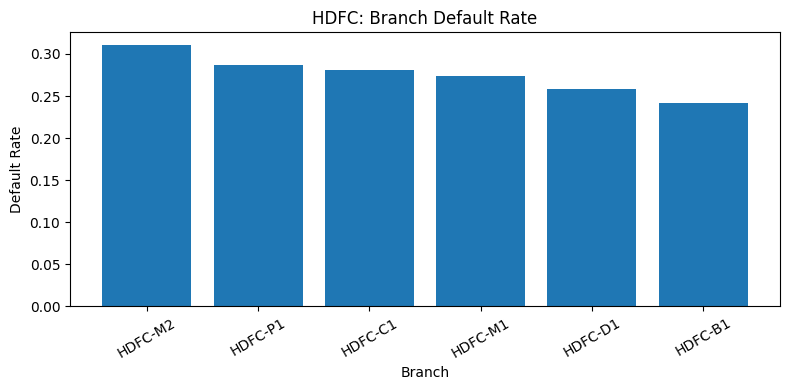

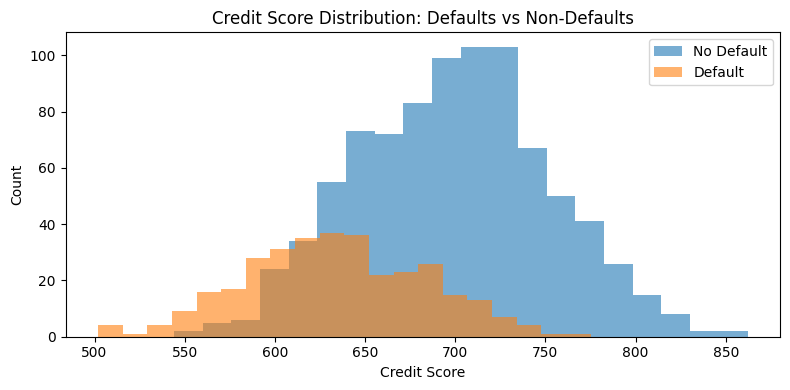

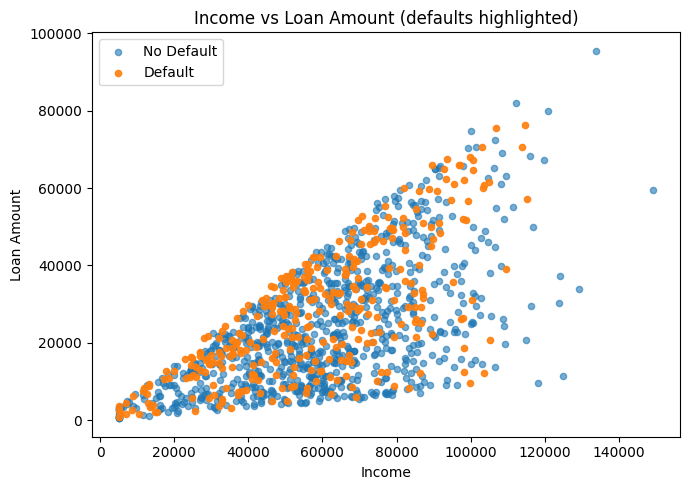

Assets saved to assets/: ['branch_performance.png', 'income_vs_loan_default.png', 'default_by_region.png', 'high_risk_segments.csv', 'default_by_region.csv', 'credit_score_distribution.png', 'branch_performance.csv', 'default_credit_util.png']


In [4]:
# Cell D — analysis + matplotlib visuals (save CSVs + PNGs)
import pandas as pd, matplotlib.pyplot as plt, os
df = pd.read_csv('data/hdfc_processed_loans.csv')

# default by region
default_region = df.groupby('region')['default'].mean().reset_index().rename(columns={'default':'default_rate'})
default_region['default_rate'] = default_region['default_rate'].round(4)
default_region.to_csv('assets/default_by_region.csv', index=False)

plt.figure(figsize=(7,4))
plt.bar(default_region['region'], default_region['default_rate'])
plt.title('HDFC: Default Rate by Region')
plt.xlabel('Region'); plt.ylabel('Default Rate')
plt.grid(axis='y', linestyle=':', linewidth=0.6)
plt.tight_layout(); plt.savefig('assets/default_by_region.png'); plt.show()

# default by credit bucket & high_util
seg = df.groupby(['credit_bucket','high_util'])['default'].mean().reset_index().rename(columns={'default':'default_rate'})
seg['default_rate'] = seg['default_rate'].round(4)
seg.to_csv('assets/high_risk_segments.csv', index=False)

pivot = seg.pivot(index='credit_bucket', columns='high_util', values='default_rate').fillna(0)
pivot.plot(kind='bar', figsize=(8,4))
plt.title('Default Rate by Credit Bucket & High Util (HDFC)')
plt.ylabel('Default Rate')
plt.tight_layout(); plt.savefig('assets/default_credit_util.png'); plt.show()

# branch performance
branch_perf = df.groupby('branch')['default'].agg(['mean','count']).reset_index().rename(columns={'mean':'default_rate','count':'n'})
branch_perf['default_rate'] = branch_perf['default_rate'].round(4)
branch_perf.to_csv('assets/branch_performance.csv', index=False)

branch_sorted = branch_perf.sort_values('default_rate', ascending=False)
plt.figure(figsize=(8,4)); plt.bar(branch_sorted['branch'], branch_sorted['default_rate'])
plt.title('HDFC: Branch Default Rate'); plt.xlabel('Branch'); plt.ylabel('Default Rate'); plt.xticks(rotation=30)
plt.tight_layout(); plt.savefig('assets/branch_performance.png'); plt.show()

# extra plots
plt.figure(figsize=(8,4))
plt.hist(df.loc[df['default']==0, 'credit_score'], bins=20, alpha=0.6, label='No Default')
plt.hist(df.loc[df['default']==1, 'credit_score'], bins=20, alpha=0.6, label='Default')
plt.title('Credit Score Distribution: Defaults vs Non-Defaults')
plt.xlabel('Credit Score'); plt.ylabel('Count'); plt.legend()
plt.tight_layout(); plt.savefig('assets/credit_score_distribution.png'); plt.show()

plt.figure(figsize=(7,5))
plt.scatter(df.loc[df['default']==0, 'income'], df.loc[df['default']==0, 'loan_amount'], s=20, alpha=0.6, label='No Default')
plt.scatter(df.loc[df['default']==1, 'income'], df.loc[df['default']==1, 'loan_amount'], s=20, alpha=0.9, label='Default')
plt.title('Income vs Loan Amount (defaults highlighted)')
plt.xlabel('Income'); plt.ylabel('Loan Amount'); plt.legend()
plt.tight_layout(); plt.savefig('assets/income_vs_loan_default.png'); plt.show()

print("Assets saved to assets/:", os.listdir('assets')[:12])
